In [163]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()

# optimization
from scipy import optimize
from numpy.random import default_rng

# For quick OLS
#import statsmodels.formula.api as smf

# Import our toolbox
import clogit as clogit
import mlogit_ante as mlogit
import estimation as est
import LinearModels as lm

# Read in data

The dataset, `cars.csv`, contains cleaned and processed data. If you want to make changes, the notebook, `materialize.ipynb`, creates the data from the raw source datsets. 

In [164]:
cars = pd.read_csv('cars.csv')
lbl_vars = pd.read_csv('labels_variables.csv')
lbl_vals = pd.read_csv('labels_values.csv')

# convert from dataframe to dict
lbl_vals = {c: lbl_vals[c].dropna().to_dict() for c in lbl_vals.columns}

In [165]:
lbl_vars.set_index('variable', inplace=True)

## Overview of the dataset

In [166]:
lbl_vars.join(cars.mean(numeric_only=True).apply(lambda x: f'{x: .2f}').to_frame('Mean'))

,label,Mean
variable,,
ye,year (=first dimension of panel),84.50
ma,market (=second dimension of panel),3.00
co,model code (=third dimension of panel),207.50
zcode,alternative model code (predecessors and succe...,177.76
brd,brand code,16.79
type,name of brand and model,NaN
brand,name of brand,NaN
model,name of model,NaN
org,"origin code (demand side, country with which c...",2.72


In [167]:
temp = lbl_vars.join(cars.mean(numeric_only=True).apply(lambda x: f'{x: .2f}').to_frame('Mean'))
temp['label']['princ']

'=pr/(ngdp/pop): price relative to per capita income (often used in demand model)'

In [168]:
temp['label']['pr']

'price (in destination currency including V.A.T.)'

# Set up for analysis

In [169]:
price_var = 'princ'

In [170]:
cars['logp'] = np.log(cars[price_var])

<AxesSubplot: >

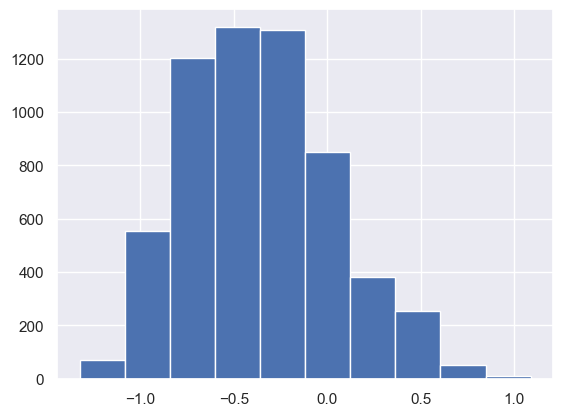

In [171]:
cars['logp'].hist()

In [172]:
# new variable: price elasticity heterogeneous for home-region 
cars['logp_x_home'] = cars['logp'] * cars['home']

# Scaling for numerical stability
cars['cy']/=1000
cars['hp']/=100
cars['we']/=1000

### Dummy variables

For working with matrices, we want to have a column for each dummy variable. 

In [173]:
categorical_var = 'brand' # name of categorical variable
dummies = pd.get_dummies(cars[categorical_var]) # creates a matrix of dummies for each value of dummyvar
x_vars_dummies = list(dummies.columns[1:].values) # omit a reference category, here it is the first (hence columns[1:])

# add dummies to the dataframe 
assert dummies.columns[0] not in cars.columns, f'It looks like you have already added this dummy to the dataframe. Avoid duplicates! '
cars = pd.concat([cars,dummies], axis=1)

In [174]:
# NB! Let's take a look at the reference category
dummies.columns[0] #This is BMW
# Something might be going on 

'BMW'

### `x_vars`: List of regressors to be used 

In [175]:
x_vars = ['logp', 'home', 'logp_x_home', 'cy', 'hp', 'we', 'li', 'he'] + x_vars_dummies
# If we include dummies for the brand, the 3-D matrix x becomes singular. Why?
# 
print(f'K = {len(x_vars)} variables selected.')

K = 40 variables selected.


In [176]:
cars['co'].nunique() #Different car models - some cars are in the top 40 most sold for a market and/or year

285

In [177]:
K = len(x_vars) #The "household" characteristics
N = cars.ma.nunique() * cars.ye.nunique() #The market-year 'i'
J = 40 #The 40 different cars
x = cars[x_vars].values.reshape((N,J,K))

In [178]:
cars['logp_x_home'].mean()

-0.09440312493294639

In [179]:
cars['logp'].mean()

-0.3606223052101118

In [180]:
y = cars['s'].values #The market shares 
y = y.reshape((N,J)) #The market shares in market-year N for J=40 different cars

In [181]:
# Let's look at a particular 'market-year' to see what is going on, for example market = 0 (Belgium) in 1970

belgium1970 = cars[(cars['ma']==1) & (cars['ye']==70)] 


# Interpretation: Each 'market-year', the top 40 most selling cars make up about 99.99% of all cars sold.
    # Each market-year share column (called "s" in the data) sums to one


In [182]:
belgium1970

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,seat,skoda,suzuki,tal/hillman,tal/matra,tal/simca,tal/sunb,talbot,toyota,volvo
0,70,1,15,14,2,audi 100/200,audi,100/200,2,4,...,0,0,0,0,0,0,0,0,0,0
1,70,1,26,35,4,citroen 2 CV 6 - 2 CV 4,citroen,2CV6,1,3,...,0,0,0,0,0,0,0,0,0,0
2,70,1,36,36,4,citroen dyane,citroen,dyane,1,3,...,0,0,0,0,0,0,0,0,0,0
3,70,1,64,67,7,fiat 128,fiat,128,3,5,...,0,0,0,0,0,0,0,0,0,0
4,70,1,71,80,8,ford escort,ford,escort,2,4,...,0,0,0,0,0,0,0,0,0,0
5,70,1,134,159,16,mercedes 200-300,mercedes,200,2,4,...,0,0,0,0,0,0,0,0,0,0
6,70,1,165,197,19,opel kadett,opel,kadet,2,4,...,0,0,0,0,0,0,0,0,0,0
7,70,1,172,194,19,opel rekord,opel,record,2,4,...,0,0,0,0,0,0,0,0,0,0
8,70,1,186,202,20,peugeot 504,peugeot,504,1,3,...,0,0,0,0,0,0,0,0,0,0
9,70,1,187,207,20,peugeot 304,peugeot,304,1,3,...,0,0,0,0,0,0,0,0,0,0


In [183]:
belgium1970['s'].sum() #The share of total sales for the top 40 most cars sum to one

0.9999999999999979

$$
u_{i j h}=\mathbf{x}_{i j} \boldsymbol{\beta}_o+\varepsilon_{i j h}, \quad j=1, \ldots, J
$$

where: 

- $i$ is the $\textit{country-year}$ pair
- $j$ is the alternative car
- $h$ is the household

First off: Are we: 

    1. interested in the marginal utility of a car's characteristic (conditional logit) or 
    
    2. the change in utility of car $j$ relative to car 1 given a change in household characteristics?

In this assignment, we are examning home bias - that is the propensity to choose a car manufactured in the home country. We are therefore interested in 1) and will use a conditional logit model.

In [184]:
# Our conditional choice probabilities
# For coefficients ('theta') starting at zero, these must be equal to zero
# Intuition: No utility is gained by any car characteristics, thus market shares must be equal. Let's check this.
theta_start = clogit.starting_values(y,x)
ccp = clogit.choice_prob(theta_start, x)
(ccp == 1/J) # all choice probs are equal to each other.

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [185]:
# In the first market-year, what are the choice-probs? (Given individuals place no weight on any car characteristics)
ccp.sum(axis=1) #Summing over the columns J equal one. Goods

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [186]:
print(ccp.shape)
np.unique(ccp) #Checking if we have any NaN

(150, 40)


array([0.025])

In [187]:
temp_df = pd.DataFrame(x[50]) #Looking at the 50th market-year
temp_df.columns=x_vars
temp_df.head()

,logp,home,logp_x_home,cy,hp,we,li,he,MCC,VW,...,seat,skoda,suzuki,tal/hillman,tal/matra,tal/simca,tal/sunb,talbot,toyota,volvo
0,-0.438650,0.0,-0.000000,1.3,0.63,0.940,7.8,135.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.226922,0.0,-0.000000,1.8,0.66,1.050,7.6,139.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.143563,0.0,-0.000000,1.6,0.75,1.080,8.5,138.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.407682,0.0,0.000000,2.0,1.10,1.425,9.8,141.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.891653,1.0,-0.891653,1.0,0.33,0.640,5.0,135.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [188]:
T=5
y_ols = np.log(y).reshape((N*J),1)
x_ols = np.hstack([np.ones((N*J,1)), x.reshape(N*J,K)])

In [189]:
y_ols.shape

(6000, 1)

In [190]:
res_ols = lm.estimate(y_ols,x_ols)
ols_out = lm.outreg(res_ols, var_labels=['cons_']+x_vars, name='OLS')


In [191]:
res = est.estimate(clogit.q2, theta_start, y, x, cov_type='Sandwich', method='BFGS') #options={'maxiter':200000} <- add if you are using Nelder-Mead for example

Optimization terminated successfully.
         Current function value: 3.471981
         Iterations: 289
         Function evaluations: 11931
         Gradient evaluations: 291


In [192]:
res_dict = {'theta_hat': res['theta'], 'se': res['se'], 't-stat':res['t'], 'cov_hat': res['cov']}
clogit_out = clogit.outreg(res_dict, var_labels=x_vars, name='Logit')

In [193]:
x_vars[:8]

['logp', 'home', 'logp_x_home', 'cy', 'hp', 'we', 'li', 'he']

In [194]:
tab1 = pd.merge(clogit_out[:8*2], ols_out[:9*2], 'right', left_index=True, right_index=True).fillna('.')
tab1

Logit       OLS
cons_       theta         .  -2.37***
            se            .   (0.311)
logp        theta   -0.25**  -0.41***
            se      (0.128)   (0.042)
home        theta   1.42***   1.04***
            se      (0.044)    (0.03)
logp_x_home theta    0.14**   0.18***
            se      (0.061)   (0.056)
cy          theta     -0.12  -0.35***
            se      (0.074)   (0.066)
hp          theta  -1.52***  -1.06***
            se      (0.187)   (0.149)
we          theta   0.65***   1.28***
            se      (0.188)   (0.127)
li          theta   -0.04**  -0.06***
            se      (0.017)   (0.008)
he          theta  -0.01***  -0.01***
            se      (0.003)   (0.002)

In [195]:
print(tab1.rename(index={'theta':'', 'se':''}).to_latex())

\begin{tabular}{llll}
\toprule
   & {} &     Logit &       OLS \\
\midrule
cons\_ & {} &         . &  -2.37*** \\
   & {} &         . &   (0.311) \\
logp & {} &   -0.25** &  -0.41*** \\
   & {} &   (0.128) &   (0.042) \\
home & {} &   1.42*** &   1.04*** \\
   & {} &   (0.044) &    (0.03) \\
logp\_x\_home & {} &    0.14** &   0.18*** \\
   & {} &   (0.061) &   (0.056) \\
cy & {} &     -0.12 &  -0.35*** \\
   & {} &   (0.074) &   (0.066) \\
hp & {} &  -1.52*** &  -1.06*** \\
   & {} &   (0.187) &   (0.149) \\
we & {} &   0.65*** &   1.28*** \\
   & {} &   (0.188) &   (0.127) \\
li & {} &   -0.04** &  -0.06*** \\
   & {} &   (0.017) &   (0.008) \\
he & {} &  -0.01*** &  -0.01*** \\
   & {} &   (0.003) &   (0.002) \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_8320\1880994701.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tab1.rename(index={'theta':'', 'se':''}).to_latex())


In [196]:
theta_hat = res_dict['theta_hat']
cov_hat = res_dict['cov_hat']

In [197]:
cov_hat

array([[ 1.63719775e-02, -1.69246107e-04, -1.52776839e-04, ...,
         1.01010529e-05, -2.45587991e-05, -9.30762888e-04],
       [-1.69246107e-04,  1.93494219e-03,  1.88337910e-03, ...,
        -6.60247903e-05, -2.94427614e-04,  2.90504470e-04],
       [-1.52776839e-04,  1.88337910e-03,  3.71569972e-03, ...,
        -6.60954863e-04, -9.20908838e-04,  5.99359435e-04],
       ...,
       [ 1.01010529e-05, -6.60247903e-05, -6.60954863e-04, ...,
         5.81010548e-03,  1.65309474e-03,  1.94384569e-04],
       [-2.45587991e-05, -2.94427614e-04, -9.20908838e-04, ...,
         1.65309474e-03,  4.29781884e-03, -1.10044974e-03],
       [-9.30762888e-04,  2.90504470e-04,  5.99359435e-04, ...,
         1.94384569e-04, -1.10044974e-03,  1.16121467e-03]])

In [198]:
theta_hat

array([-0.2536602 ,  1.42205277,  0.13869701, -0.12068846, -1.52162443,
        0.64925158, -0.03674792, -0.01194046, -1.18989656,  0.17930946,
       -0.76774873, -0.12134582, -0.47523748, -0.51768112, -0.78863372,
       -0.15280806,  0.01079063, -0.29341559, -0.72032055, -1.35456638,
       -0.97493655, -0.38385169,  0.51718291, -0.47730258, -0.17256599,
       -0.03526939, -0.07978525,  0.01100992, -0.43755445, -0.65733916,
       -0.77744072, -0.89463044, -1.18362122, -1.27901679, -2.83607786,
       -0.43058234, -3.40089892, -0.41572431, -0.06182238,  0.01338732])

In [199]:
ccp_hat = clogit.choice_prob(theta_hat, x)

In [200]:
market_share = cars['s'].values.reshape((N,J))
market_share[0] # For the first market-year, what are the observed market shares of the 40 different cars?

array([0.01129646, 0.01464355, 0.02803195, 0.03263421, 0.03974679,
       0.02786459, 0.04393066, 0.0460226 , 0.02091936, 0.01025049,
       0.03598131, 0.02991469, 0.03347098, 0.01861823, 0.03075147,
       0.03911921, 0.05857422, 0.01255162, 0.00920452, 0.00878613,
       0.00920452, 0.01548033, 0.01945501, 0.03127445, 0.01799065,
       0.01380678, 0.00962291, 0.03012388, 0.03179743, 0.01045968,
       0.01108726, 0.02259291, 0.02322049, 0.02510324, 0.02656759,
       0.05899261, 0.01589872, 0.02091936, 0.03233297, 0.02175614])

In [201]:
ccp_hat[0] # For the first market-year, what are the estimated market shares of the 40 different cars given our control variables?

array([0.01739914, 0.02260737, 0.02371833, 0.02409675, 0.03661417,
       0.027083  , 0.02993979, 0.02919435, 0.01789385, 0.0228626 ,
       0.03706877, 0.02580733, 0.03487534, 0.02824443, 0.02455711,
       0.02299095, 0.03991113, 0.02311779, 0.02646776, 0.01757049,
       0.01374869, 0.02309152, 0.0108937 , 0.01927279, 0.02257808,
       0.01956035, 0.01490893, 0.03436949, 0.03155966, 0.01677118,
       0.02338755, 0.02959199, 0.0289206 , 0.02034579, 0.03489161,
       0.02340906, 0.02120393, 0.03646579, 0.01792578, 0.02508305])

The Delta Method tells us how to compute standard errors for $\mathbf{h}(\hat{\boldsymbol{\theta}})$ based on an estimated covariance matrix for $\hat{\boldsymbol{\theta}}$. To do this, define the $K \times K$ matrix of derivatives of $\mathbf{h}$
$$ \mathbf{g} = \nabla_\theta \mathbf{h}(\hat{\boldsymbol{\theta}}).$$

Then we have 
$$ \text{Avar}[\mathbf{h}(\hat{\boldsymbol{\theta}})] = \mathbf{g} \, \text{Avar}(\hat{\boldsymbol{\theta}}) \, \mathbf{g}'$$
 
From the note, we have 

$$ \mathbf{g} = \phi(\mathbf{x}_0 \hat{\boldsymbol{\beta}}) 
    \left [\mathbf{I}_{K\times K} - (\hat{\boldsymbol{\beta}} \hat{\boldsymbol{\beta}}') (\mathbf{x}_0' \mathbf{x}_0) \right] $$ 

Note that both $\hat{\boldsymbol{\beta}} \hat{\boldsymbol{\beta}}'$ and $\mathbf{x}_0' \mathbf{x}_0$ are $K \times K$ matrices (outer products). 

---

### Numerical elasticities using the Delta method

In [202]:
def own_elasticity_numerical(x, theta, h=0.01):

    ccp1 = clogit.choice_prob(theta, x)

    N,J = ccp1.shape

    E_own   = np.zeros((N, J))
    E_cross = np.zeros((N, J))
    dpdx    = np.zeros((N, J))
    k_price = 0 
    k_home = 1
    k_price_x_home = 2

    for j in range(J):
        # A. copy 
        x2 = x.copy()
        
        # B. increase price just for car j 
        rel_change_x = h
        x2[:, j, k_price] += h # log p changes
        x2[:, j, k_price_x_home] = x2[:, j, k_price]*x2[:, j, k_home] # logp_x_home changes as well

        # C. evaluate CCPs
        ccp2 = clogit.choice_prob(theta, x2) # Fill in     

        # D. percentage change in CCPs 
        rel_change_y = ccp2/ccp1-1 # Fill in 
        
        # E. elasticities 
        elasticity = (rel_change_y/rel_change_x) # Fill in 
        
        E_own[:, j] = elasticity[:, j] # Fill in 
        
        k_not_j = [k for k in range(J) if k != j] # indices for all other cars than j -> this list changes as we loop through j
        E_cross[:, j] = elasticity[:, k_not_j].mean(axis=1) # Fill in: Avg. among the cars k_not_j, taking the average over axis=1 (the cars, not the individuals!)
    
        return E_own.mean()

In [203]:
def cross_elasticity_numerical(x, theta, h=0.01):

    ccp1 = clogit.choice_prob(theta, x)

    N,J = ccp1.shape

    E_own   = np.zeros((N, J))
    E_cross = np.zeros((N, J))
    dpdx    = np.zeros((N, J))
    k_price = 0 
    k_home = 1
    k_price_x_home = 2

    for j in range(J):
        # A. copy 
        x2 = x.copy()
        
        # B. increase price just for car j 
        rel_change_x = h
        x2[:, j, k_price] += h # log p changes
        x2[:, j, k_price_x_home] = x2[:, j, k_price]*x2[:, j, k_home] # logp_x_home changes as well

        # C. evaluate CCPs
        ccp2 = clogit.choice_prob(theta, x2) # Fill in     

        # D. percentage change in CCPs 
        rel_change_y = ccp2/ccp1-1 # Fill in 
        
        # E. elasticities 
        elasticity = (rel_change_y/rel_change_x) # Fill in 
        
        E_own[:, j] = elasticity[:, j] # Fill in 
        
        k_not_j = [k for k in range(J) if k != j] # indices for all other cars than j -> this list changes as we loop through j
        E_cross[:, j] = elasticity[:, k_not_j].mean(axis=1) # Fill in: Avg. among the cars k_not_j, taking the average over axis=1 (the cars, not the individuals!)
    
        return E_cross.mean()

In [204]:
def own_elasticity_numerical_home(x, theta, h=0.01):

    ccp1 = clogit.choice_prob(theta, x)

    N,J = ccp1.shape

    E_own   = np.zeros((N, J))
    E_cross = np.zeros((N, J))
    dpdx    = np.zeros((N, J))
    k_price = 0 
    k_home = 1
    k_price_x_home = 2

    idx_home = x[:, :, k_home] == 1

    for j in range(J):
        # A. copy 
        x2 = x.copy()
        
        # B. increase price just for car j 
        rel_change_x = h
        x2[:, j, k_price] += h # log p changes
        x2[:, j, k_price_x_home] = x2[:, j, k_price]*x2[:, j, k_home] # logp_x_home changes as well

        # C. evaluate CCPs
        ccp2 = clogit.choice_prob(theta, x2) # Fill in     

        # D. percentage change in CCPs 
        rel_change_y = ccp2/ccp1-1 # Fill in 
        
        # E. elasticities 
        elasticity = (rel_change_y/rel_change_x) # Fill in 
        
        E_own[:, j] = elasticity[:, j] # Fill in 
        
        k_not_j = [k for k in range(J) if k != j] # indices for all other cars than j -> this list changes as we loop through j
        E_cross[:, j] = elasticity[:, k_not_j].mean(axis=1) # Fill in: Avg. among the cars k_not_j, taking the average over axis=1 (the cars, not the individuals!)
    
        return E_own[idx_home].mean()

In [205]:
def own_elasticity_numerical_foreign(x, theta, h=0.01):

    ccp1 = clogit.choice_prob(theta, x)

    N,J = ccp1.shape

    E_own   = np.zeros((N, J))
    E_cross = np.zeros((N, J))
    dpdx    = np.zeros((N, J))
    k_price = 0 
    k_home = 1
    k_price_x_home = 2

    idx_foreign = x[:, :, k_home] == 0

    for j in range(J):
        # A. copy 
        x2 = x.copy()
        
        # B. increase price just for car j 
        rel_change_x = h
        x2[:, j, k_price] += h # log p changes
        x2[:, j, k_price_x_home] = x2[:, j, k_price]*x2[:, j, k_home] # logp_x_home changes as well

        # C. evaluate CCPs
        ccp2 = clogit.choice_prob(theta, x2) # Fill in     

        # D. percentage change in CCPs 
        rel_change_y = ccp2/ccp1-1 # Fill in 
        
        # E. elasticities 
        elasticity = (rel_change_y/rel_change_x) # Fill in 
        
        E_own[:, j] = elasticity[:, j] # Fill in 
        
        k_not_j = [k for k in range(J) if k != j] # indices for all other cars than j -> this list changes as we loop through j
        E_cross[:, j] = elasticity[:, k_not_j].mean(axis=1) # Fill in: Avg. among the cars k_not_j, taking the average over axis=1 (the cars, not the individuals!)
    
        return E_own[idx_foreign].mean()

In [206]:
E_own = own_elasticity_numerical(x, theta_hat).round(3)
E_cross = cross_elasticity_numerical(x, theta_hat).round(3)

E_own_home = own_elasticity_numerical_home(x, theta_hat).round(3)
E_own_foreign = own_elasticity_numerical_foreign(x, theta_hat).round(3)

In [207]:
def delta(func, theta_hat, cov_hat, x, **kwargs):
    # Pass any function requiring multiple inputs.
    # Turn this into an anonymous single-input with 'theta-hat' as input (ie. regression coefficient as per the delta method)
    z = lambda coef: func(x, coef, **kwargs)  

    # Calculate the gradient of elasticities/partial effects w.r.t model parameters 
    grad = est.centered_grad(z, theta_hat)

    # Calculate covariance-variance matrix based on estimated covariance-variance "cov_hat" from regresion
    cov_marg_eff = grad@cov_hat@grad.T

    # Return standard errors, ie. sqrt of the diagonals 
    se = np.sqrt(np.diag(cov_marg_eff))
    return se

In [208]:
E_own_se = delta(own_elasticity_numerical, theta_hat, cov_hat, x).round(3)
E_cross_se = delta(cross_elasticity_numerical, theta_hat, cov_hat, x).round(3)

E_own_home_se = delta(own_elasticity_numerical_home, theta_hat, cov_hat, x).round(3)
E_own_foreign_se = delta(own_elasticity_numerical_foreign, theta_hat, cov_hat, x).round(3)

In [209]:
# Create two indexed, where idx_home is for home-produced cars
# and idx_foreign is for foreign-produced cars.
k_home = 1
idx_home = x[:, :, k_home]==1 
idx_foreign = x[:, :, k_home]==0 

In [210]:
se = [E_own_se[0], E_cross_se[0], E_own_home_se[0], E_own_foreign_se[0]]
elas = [E_own, E_cross, E_own_home, E_own_foreign]
elas_res = {'Est.': elas, 'SE': se}

tab = pd.DataFrame(elas_res, index=['Own-price elasticity', 'Cross-price elasticity', 'Own-price elasticity (home)', 'Own-price elasticity (foreign)'])
tab

,Est.,SE
Own-price elasticity,-0.005,0.003
Cross-price elasticity,0.000,0.000
Own-price elasticity (home),-0.003,0.004
Own-price elasticity (foreign),-0.006,0.003


In [211]:
print(tab.to_latex())

\begin{tabular}{lrr}
\toprule
{} &   Est. &     SE \\
\midrule
Own-price elasticity           & -0.005 &  0.003 \\
Cross-price elasticity         &  0.000 &  0.000 \\
Own-price elasticity (home)    & -0.003 &  0.004 \\
Own-price elasticity (foreign) & -0.006 &  0.003 \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_8320\1489069591.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(tab.to_latex())


In [212]:
def own_elasticity_numerical(x, theta, h=0.01):

    ccp1 = clogit.choice_prob(theta, x)

    N,J = ccp1.shape

    E_own   = np.zeros((N, J))
    E_cross = np.zeros((N, J))
    dpdx    = np.zeros((N, J))
    k_price = 0 
    k_home = 1
    k_price_x_home = 2

    idx_home = x[:, :, k_home] == 1

    for j in range(J):
        # A. copy 
        x2 = x.copy()
        
        # B. increase price just for car j 
        rel_change_x = h
        x2[:, j, k_price] += h # log p changes
        x2[:, j, k_price_x_home] = x2[:, j, k_price]*x2[:, j, k_home] # logp_x_home changes as well

        # C. evaluate CCPs
        ccp2 = clogit.choice_prob(theta, x2) # Fill in     

        # D. percentage change in CCPs 
        rel_change_y = ccp2/ccp1-1 # Fill in 
        
        # E. elasticities 
        elasticity = (rel_change_y/rel_change_x) # Fill in 
        
        E_own[:, j] = elasticity[:, j] # Fill in 
        
        k_not_j = [k for k in range(J) if k != j] # indices for all other cars than j -> this list changes as we loop through j
        E_cross[:, j] = elasticity[:, k_not_j].mean(axis=1) # Fill in: Avg. among the cars k_not_j, taking the average over axis=1 (the cars, not the individuals!)
    
        return E_own

In [227]:
def own_elasticity_numerical_simul_home(x, theta, h=0.01):
    
    ccp1 = clogit.choice_prob(theta, x)

    N,J = ccp1.shape

    E_own   = np.zeros((N, J))
    E_cross = np.zeros((N, J))
    dpdx    = np.zeros((N, J))
    k_price = 0 
    k_home = 1
    k_price_x_home = 2

    idx_home = x[:, :, k_home] == 1

    x2 = x.copy()
    x2[:,:,k_price][idx_home] += h
    x2[:,:,k_price_x_home] = x2[:,:,k_price]*x2[:,:,k_home]

    # C. evaluate CCPs
    ccp2 = clogit.choice_prob(theta, x2) # Fill in 

    # D. percentage change in CCPs 
    rel_change_y = ccp2/ccp1-1 # Fill in 
    rel_change_x = h

    elasticity = (rel_change_y/rel_change_x) # Fill in

    for j in range(J):
        E_own[:, j] = elasticity[:, j] # Fill in 

        k_not_j = [k for k in range(J) if k != j] # indices for all other cars than j -> this list changes as we loop through j
        E_cross[:, j] = elasticity[:, k_not_j].mean(axis=1) # Fill in: Avg. among the cars k_not_j, taking the average over axis=1 (the cars, not the individuals!) 

    return E_own[idx_home].mean()

In [236]:
def own_elasticity_numerical_simul_foreign(x, theta, h=0.01):
    
    ccp1 = clogit.choice_prob(theta, x)

    N,J = ccp1.shape

    E_own   = np.zeros((N, J))
    E_cross = np.zeros((N, J))
    dpdx    = np.zeros((N, J))
    k_price = 0 
    k_home = 1
    k_price_x_home = 2

    idx_home = x[:, :, k_home] == 1
    idx_foreign = x[:, :, k_home] == 0

    x2 = x.copy()
    x2[:,:,k_price][idx_home] += h
    x2[:,:,k_price_x_home] = x2[:,:,k_price]*x2[:,:,k_home]

    # C. evaluate CCPs
    ccp2 = clogit.choice_prob(theta, x2) # Fill in 

    # D. percentage change in CCPs 
    rel_change_y = ccp2/ccp1-1 # Fill in 
    rel_change_x = h

    elasticity = (rel_change_y/rel_change_x) # Fill in

    for j in range(J):
        E_own[:, j] = elasticity[:, j] # Fill in 

        k_not_j = [k for k in range(J) if k != j] # indices for all other cars than j -> this list changes as we loop through j
        E_cross[:, j] = elasticity[:, k_not_j].mean(axis=1) # Fill in: Avg. among the cars k_not_j, taking the average over axis=1 (the cars, not the individuals!) 

    return E_own[idx_foreign].mean()

In [228]:
own_elasticity_numerical_home(x, theta_hat)

-0.002883305016613132

In [229]:
own_elasticity_numerical_simul_home(x, theta_hat)

-0.03366420121563944

In [234]:
delta(own_elasticity_numerical_simul_home, theta_hat, cov_hat, x)

0.041234519143622056

In [237]:
own_elasticity_numerical_simul_foreign(x, theta_hat)

0.055339465326097306

In [238]:
delta(own_elasticity_numerical_simul_foreign, theta_hat, cov_hat, x)

array([0.06768191])

In [220]:
delta(own_elasticity_numerical_home, theta_hat, cov_hat, x)

array([0.00352556])

### Delta method to calculate std. errors of the average difference between home and foreign own-price elasticities

$$
\mathcal{E}_{j j}^D-\mathcal{E}_{j j}^F
$$

In [57]:
def own_elasticity_numerical_diff(x, theta, h=0.01):

    ccp1 = clogit.choice_prob(theta, x)

    N,J = ccp1.shape

    E_own   = np.zeros((N, J))
    E_cross = np.zeros((N, J))
    dpdx    = np.zeros((N, J))
    k_price = 0 
    k_home = 1
    k_price_x_home = 2

    idx_home_ = x[:, :, k_home] == 1
    idx_foreign_ = x[:, :, k_home] == 0

    for j in range(J):
        # A. copy 
        x2 = x.copy()
        
        # B. increase price just for car j 
        rel_change_x = h
        x2[:, j, k_price] += h # log p changes
        x2[:, j, k_price_x_home] = x2[:, j, k_price]*x2[:, j, k_home] # logp_x_home changes as well

        # C. evaluate CCPs
        ccp2 = clogit.choice_prob(theta, x2) # Fill in     

        # D. percentage change in CCPs 
        rel_change_y = ccp2/ccp1-1 # Fill in 
        
        # E. elasticities 
        elasticity = (rel_change_y/rel_change_x) # Fill in 
        
        E_own[:, j] = elasticity[:, j] # Fill in 
        
        k_not_j = [k for k in range(J) if k != j] # indices for all other cars than j -> this list changes as we loop through j
        E_cross[:, j] = elasticity[:, k_not_j].mean(axis=1) # Fill in: Avg. among the cars k_not_j, taking the average over axis=1 (the cars, not the individuals!)
    
        return E_own[idx_home].mean()-E_own[idx_foreign].mean()

In [58]:
diff = own_elasticity_numerical_diff(x, theta_hat)
diff_se = delta(own_elasticity_numerical, theta_hat, cov_hat, x).mean()

In [59]:
diff.round(3)

0.003

In [60]:
diff_se.round(4)

0.0032

In [61]:
t_diff = (diff/diff_se).round(2)
t_diff

1.01

### Compensating variation

$$
\mathrm{CV}=\frac{1}{\beta_p} \log \sum_{j=1}^J \exp \left(v_{i j}\right)-\frac{1}{\beta_p} \log \sum_{j=1}^J \exp \left(\tilde{v}_{i j}\right)
$$

$\beta_p$ is the price coefficient from the logit regression. Given that we have log prices, we take the `exp`-function of this coefficient.

In [62]:
v = x@theta_hat

In [63]:
x.shape

(150, 40, 40)

In [64]:
theta_hat.shape

(40,)

In [65]:
np.exp(v[idx_home]).sum()

728.9008969481099

In [66]:
np.exp(v[idx_foreign]).sum()

434.8708692904612

In [67]:
k_price = 0
k_price_x_home =   2

CV = 1/np.exp(theta_hat[k_price]) * np.log(np.exp(v[idx_foreign]).sum()) - 1/np.exp(theta_hat[k_price]+theta_hat[k_price_x_home]) * np.log(np.exp(v[idx_home]).sum())

In [68]:
CV.round(2)

0.43

In [69]:
def CV(x, theta_hat):
    k_price = 0
    k_price_x_home =   2

    v = x@theta_hat

    CV = 1/np.exp(theta_hat[k_price]) * np.log(np.exp(v[idx_foreign]).sum()) - 1/np.exp(theta_hat[k_price]+theta_hat[k_price_x_home]) * np.log(np.exp(v[idx_home]).sum())

    return CV

In [70]:
delta(CV, theta_hat, cov_hat, x)

array([0.45028062])

### Partial effects

1) Focusing on all markets and all cars
2) Segmenting on lower and upper half of the prices of cars

In [71]:
lower_half = cars[cars['logp']<cars['logp'].quantile(0.50)]
upper_half = cars[cars['logp']>cars['logp'].quantile(0.50)]

K = len(x_vars) #The "household" characteristics
N_low = lower_half.ma.nunique() * upper_half.ye.nunique()
N_high = upper_half.ma.nunique() * upper_half.ye.nunique()
J_half = int(J/2) #The 20 different cars
x_low=lower_half[x_vars].values.reshape(N,J_half,K)
x_high=upper_half[x_vars].values.reshape(N,J_half,K)

k_home = 1

# Boolean array for home-produced cars, for lower & upper half respectively
idx_home_low = x_low[:, :, k_home]==1
idx_home_high = x_high[:, :, k_home]==1

# Boolean array for foreign-produced cars, for lower & upper half respectively 
idx_foreign_low = x_low[:, :, k_home]==0
idx_foreign_high = x_high[:, :, k_home]==0

In [72]:
median = cars['logp'].quantile(0.50)

In [73]:
median

-0.38278115767028287

In [78]:
def marg_eff_discrete(
    x, 
    theta_hat, 
    home
    ):
    
    x_partial_0 = x.copy()
    x_partial_1 = x.copy()

    k_price = 0
    k_home = 1
    k_price_x_home = 2

    idx_home = x[:, :, k_home]==1
    idx_foreign = x[:, :, k_home]==0

    x_partial_0[:,:, k_home]=0
    x_partial_0[:, :, k_price_x_home]=x_partial_0[:,:, k_price]*x_partial_0[:,:, k_home]

    x_partial_1[:, :, k_home] = 1
    x_partial_1[:, :, k_price_x_home] = x_partial_1[:, :, k_price]*x_partial_1[:, :, k_home]

    ccp_grad = clogit.choice_prob(theta_hat, x_partial_1)-clogit.choice_prob(theta_hat, x_partial_0)
    # Specify as to look at the difference in choice probabilities for cars that were in fact home-produced or were in fact foreign-produced

    if home == True:
        ccp_grad = ccp_grad[idx_home].sum()
    else: 
        ccp_grad = ccp_grad[idx_foreign].sum()
    return ccp_grad

In [83]:
# Partial effect of home production

# Whole market
whole_market_price_eff = marg_eff_discrete(x, theta_hat, home=True)

# Lower half (cheaper cars)
lower_half_price_eff = marg_eff_discrete(x_low, theta_hat, home=True)

# Upper half (more expensive cars)
upper_half_price_eff = marg_eff_discrete(x_high, theta_hat, home=True)

In [94]:
marg_eff_discrete(x, theta_hat, home=True)

0.11298914208376841

In [95]:
marg_eff_discrete(x, theta_hat, home=False)

-0.11298914208376855

In [96]:
marg_eff_discrete(x_low, theta_hat, home=True)

0.05231888145060233

In [97]:
marg_eff_discrete(x_low, theta_hat, home=False)

-0.052318881450602664

In [456]:
se_all= delta(marg_eff_discrete, theta_hat, cov_hat, x, home=True)
se_upper_half = delta(marg_eff_discrete, theta_hat, cov_hat, x_high, home=True)
se_lower_half = delta(marg_eff_discrete, theta_hat, cov_hat, x_low, home=True)

In [457]:
part_effects = [whole_market_price_eff, lower_half_price_eff, upper_half_price_eff]
se_price = [se_all[0].round(3), se_lower_half[0].round(3), se_upper_half[0].round(3)]
t = [i/j for i,j in zip(part_effects, se_price)]

In [458]:
part_effects_dict = {'Partial effect': part_effects, 'SE': se_price, 't':t}
print(pd.DataFrame(part_effects_dict, index=['Whole market', 'Lower half', 'Upper half']).round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  Partial effect &     SE &      t \\
\midrule
Whole market &           0.113 &  0.046 &  2.456 \\
Lower half   &           0.052 &  0.023 &  2.275 \\
Upper half   &          -0.059 &  0.031 & -1.893 \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_6768\1436933095.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(part_effects_dict, index=['Whole market', 'Lower half', 'Upper half']).round(3).to_latex())


In [ ]:
E_own_high = own_elasticity_numerical(x_high, theta_hat)
E_own_low = own_elasticity_numerical(x_low, theta_hat)

In [ ]:
E_own_high_home = E_own_high[idx_home_high]
E_own_high_home.mean()

-0.0024114610322768897

In [ ]:
E_own_low_home = E_own_low[idx_home_low]
E_own_low_home.mean()

-0.0023351512040170777

In [ ]:
E_own_high_se = delta(own_elasticity_numerical, theta_hat, cov_hat, x_high)
E_own_low_se = delta(own_elasticity_numerical, theta_hat, cov_hat, x_low)

In [ ]:
E_own_high_home_se = E_own_high_se[idx_home_high.flatten()].mean()
E_own_high_home_se

0.002949198607549271

In [ ]:
E_own_low_home_se = E_own_low_se[idx_home_low.flatten()].mean()
E_own_low_home_se

0.0028555581744584132

---

# Old stuff (analytical derivatives, delta/bootstrap messy code)

---

In [127]:
def marg_eff_discrete_test(
    x, 
    theta_hat, 
    home
    ):

    N,J,K = x.shape

    k_price = 0
    k_home = 1
    k_price_x_home = 2

    x_partial_0 = x.copy()
    x_partial_1 = x.copy()

    idx_home = (x[:, :, k_price]>median) & (x[:,:,k_home] == 1)
    idx_foreign = (x[:, :, k_price]>median) & (x[:,:,k_home] == 0)

    x_partial_0[:,:, k_home]=0
    x_partial_0[:, :, k_price_x_home]=x_partial_0[:,:, k_price]*x_partial_0[:,:, k_home]

    x_partial_1[:, :, k_home] = 1
    x_partial_1[:, :, k_price_x_home] = x_partial_1[:, :, k_price]*x_partial_1[:, :, k_home]

    ccp_grad = clogit.choice_prob(theta_hat, x_partial_1)-clogit.choice_prob(theta_hat, x_partial_0)
    # Specify as to look at the difference in choice probabilities for cars that were in fact home-produced or were in fact foreign-produced

    if home == True:
        ccp_grad = ccp_grad[idx_home]
    else: 
        ccp_grad = ccp_grad[idx_foreign]
    return ccp_grad

In [136]:
test = (x[:, :, k_price]>median) & (x[:,:,k_home] == 1)
new = x[test]

In [ ]:
new[:, :, k_home]

In [130]:
marg_eff_discrete_test(x, theta_hat, home=False).shape

(1898,)

In [131]:
marg_eff_discrete_test(x, theta_hat, home=False).shape

(1898,)

In [ ]:
def cross_price_elas(x, theta):

    N,J,K = x.shape
    E       = np.zeros((N,J))
    k_price = 0
    k_home = 1
    k_price_x_home = 2    

    ccp = clogit.choice_prob(theta, x)

    # analytical
    for j in range(J):
        k_not_j = [k for k in range(J) if k != j]
        E[:, j] = np.mean(-(theta[k_price]+x[:,k_not_j,k_home]*theta[k_price_x_home])*ccp[:, k_not_j], axis=1)
    
    
    return np.mean(E)

In [ ]:
def own_price_elas(x, theta):
    N,J,K = x.shape
    E       = np.zeros((N,J))
    k_price = 0
    k_home = 1
    k_price_x_home = 2
    
    ccp = clogit.choice_prob(theta, x)
    
    # Analytically 
    for j in range(J):
        E[:, j] = (theta[k_price]+x[:,j,k_home]*theta[k_price_x_home])*(1-ccp[:,j])
    
    return np.mean(E)

In [ ]:
def own_price_elas_home(x, theta):
    N,J,K = x.shape
    E       = np.zeros((N,J))
    k_price = 0
    k_home = 1
    k_price_x_home = 2
    
    ccp = clogit.choice_prob(theta, x)
    
    # Analytically 
    for j in range(J):
        E[:, j] = (theta[k_price]+x[:,j,k_home]*theta[k_price_x_home])*(1-ccp[:,j])
        idx = x[:, :, 1]==1 #Evaluated at all home-produced cars
    
    return np.mean(E[idx])

In [ ]:
def own_price_elas_foreign(x, theta):
    N,J,K = x.shape
    E       = np.zeros((N,J))
    k_price = 0
    k_home = 1
    k_price_x_home = 2
    
    ccp = clogit.choice_prob(theta, x)
    
    # Analytically 
    for j in range(J):
        E[:, j] = (theta[k_price]+x[:,j,k_home]*theta[k_price_x_home])*(1-ccp[:,j])
        idx = x[:, :, 1]==0 #Evaluated at all foreign-produced cars
    
    return np.mean(E[idx])

In [ ]:
own_price_elas(x, theta_hat)

-0.20536080697229842

In [ ]:
own_price_elas_home(x, theta_hat)

-0.10994118393908991

In [ ]:
own_price_elas_foreign(x, theta_hat)

-0.24951157355372933

In [ ]:
cross_price_elas(x, theta_hat)

0.004424907588514078

In [ ]:
def delta(func,cov_hat, theta_hat, x):
    h = func(x, theta_hat) #This calculates the own-price/cross-price elasiticity
    h2 = lambda coef: func(x, coef) #Defining a helper function that takes a single input (estimates from our logit model). So this can be passed to the gradient function
    grad = est.centered_grad(h2, theta_hat) #Gradient evaluated of the output at the given theta_hat
    variance = grad@cov_hat@grad.T 
    se = np.sqrt(np.diag(variance))
    t_stat = h/se 
    res = {'theta_hat': h.round(3), 'se': se[0].round(4), 't-stat': t_stat[0].round(4)}
    return res

In [ ]:
own_price_elas_dict = delta(own_price_elas, cov_hat, theta_hat, x)
cross_price_elas_dict = delta(cross_price_elas, cov_hat, theta_hat, x)

own_price_elas_dict_home = delta(own_price_elas_home, cov_hat, theta_hat, x)
own_price_elas_dict_foreign = delta(own_price_elas_foreign, cov_hat, theta_hat, x)

In [ ]:
tab1 = clogit.outreg(own_price_elas_dict, var_labels=['Own-price elasticity'], name='Elasticity')

tab2 = clogit.outreg(own_price_elas_dict_home, var_labels=['Own-price elasticity - home produced'], name='Elasticity')

tab3 = clogit.outreg(own_price_elas_dict_foreign, var_labels=['Own-price elasticity - foreign produced'], name='Elasticity')

tab4 = clogit.outreg(cross_price_elas_dict, var_labels=['Cross-price elasticity'], name='Elasticity')

tabs = [tab1, tab2, tab3, tab4]

print(pd.concat(tabs).rename(index={'theta': '', 'se': ''}).to_latex())


\begin{tabular}{lll}
\toprule
                       & {} & Elasticity \\
\midrule
Own-price elasticity & {} &       -0.2 \\
                       & {} &    (0.126) \\
Own-price elasticity - home produced & {} &      -0.11 \\
                       & {} &    (0.134) \\
Own-price elasticity - foreign produced & {} &    -0.25** \\
                       & {} &    (0.126) \\
Cross-price elasticity & {} &        0.0 \\
                       & {} &    (0.003) \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_2644\3832926791.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(tabs).rename(index={'theta': '', 'se': ''}).to_latex())


In [ ]:
def bootstrap_sample(y,x): 
    '''bootstrap_sample: samples a new dataset (with replacement) from the input. 
    Args. 
        y: 1-dimensional N-array
        x: (N,K) matrix 
    Returns
        tuple: y_i, x_i 
            y_i: N-array
            x_i: (N,K) matrix 
    '''
    N,K = y.shape
    
    # FILL IN 
    ii_boot = np.random.choice(N, N, replace=True) # vector of indices for rows 

    y_i = y[ii_boot] # selection of N rows from y 
    x_i = x[ii_boot] # selection of N rows from x 
    
    return y_i, x_i 

In [ ]:
nboot = 1000  # Number of bootstraps, should ideally be very large 

# Set seed for random sampling.
seed = 42
rng = default_rng()

# initialize 
E_own = np.empty((nboot,J))
E_own_home = np.empty((nboot,J))
E_own_foreign = np.empty((nboot, J))
E_cross = np.empty((nboot,J))

for i in range(nboot): 
    print(f'Bootstrap iteration {i+1}/{nboot}')
    
    # 1. choose which individuals to draw
    y_i, x_i = bootstrap_sample(y,x) # Fill in: call the bootstrap sample function 
    # 2. estimate and compute 

    res = est.estimate(clogit.q2,theta_start, y_i, x_i, cov_type='Sandwich')

    theta_hat_boot = res['theta']

    ccp_i = clogit.choice_prob(theta_hat_boot, x_i)

    own_p_elas = own_price_elas_num(x_i, theta_hat_boot)
    own_p_elas_home = own_price_elas_num_home(x_i, theta_hat_boot)
    own_p_elas_foreign = own_price_elas_num_foreign(x_i, theta_hat_boot)
    cross_p_elas = cross_price_elas_num(x_i, theta_hat_boot)

    E_own[i,:] = own_p_elas
    E_own_home[i, :] = own_p_elas_home
    E_own_foreign[i, :] = own_p_elas_foreign
    
    E_cross[i,:] = cross_p_elas

Bootstrap iteration 1/1000
Optimization terminated successfully.
         Current function value: 3.483091
         Iterations: 263
         Function evaluations: 10865
         Gradient evaluations: 265
Failed to compute std. errs.: got error "Singular matrix"


NameError: name 'own_price_elas_num' is not defined

2) Bootstrapping

In [ ]:
res_bootstrap_own_p = {'theta_hat': np.mean(E_own).round(3), 'se': np.std(E_own).round(4), 't-stat': np.mean(E_own).round(3)/np.std(E_own).round(4)}

res_bootstrap_own_p_home = {'theta_hat': np.mean(E_own_home).round(3), 'se': np.std(E_own_home).round(4), 't-stat': np.mean(E_own_home).round(3)/np.std(E_own).round(4)}

res_bootstrap_own_p_foreign = {'theta_hat': np.mean(E_own_foreign).round(3), 'se': np.std(E_own_foreign).round(4), 't-stat': np.mean(E_own_foreign).round(3)/np.std(E_own).round(4)}

res_bootstrap_cross_p = {'theta_hat': np.mean(E_cross).round(3), 'se': np.std(E_cross).round(4), 't-stat': np.mean(E_cross).round(3)/np.std(E_cross).round(4)}

In [ ]:
tab1 = clogit.outreg(res_bootstrap_own_p, var_labels=['Own-price elasticity'], name='NUMERICAL Elasticity (bootstrap)')

tab2 = clogit.outreg(res_bootstrap_own_p_home, var_labels=['Own-price elasticity - home produced'], name='NUMERICAL Elasticity (bootstrap)')

tab3 = clogit.outreg(res_bootstrap_own_p_foreign, var_labels=['Own-price elasticity - foreign produced'], name='NUMERICAL Elasticity (bootstrap)')

tab4 = clogit.outreg(res_bootstrap_cross_p, var_labels=['Cross-price elasticity'], name='NUMERICAL Elasticity (bootstrap)')

tabs = [tab1, tab2, tab3, tab4]

print(pd.concat(tabs).rename(index={'theta': '', 'se': ''}).to_latex())

\begin{tabular}{lll}
\toprule
                       & {} & NUMERICAL Elasticity (bootstrap) \\
\midrule
Own-price elasticity & {} &                             -0.0 \\
                       & {} &                          (0.003) \\
Own-price elasticity - home produced & {} &                             -0.0 \\
                       & {} &                          (0.004) \\
Own-price elasticity - foreign produced & {} &                           -0.01* \\
                       & {} &                          (0.003) \\
Cross-price elasticity & {} &                              0.0 \\
                       & {} &                            (0.0) \\
\bottomrule
\end{tabular}



C:\Users\JBH\AppData\Local\Temp\ipykernel_21196\990101563.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat(tabs).rename(index={'theta': '', 'se': ''}).to_latex())


In [ ]:
def marg_eff_discrete2(
    x, 
    theta_hat, 
    home,
    expensive
    ):
    
    x_partial_0 = x.copy()
    x_partial_1 = x.copy()

    k_price = 0
    k_home = 1
    k_price_x_home = 2
    
    # Boolean array for home-produced cars, for lower & upper half respectively
    idx_home_low = (x[:, :, k_price]<median) & (x[:, :, k_home] == 1)
    idx_home_high = (x[:, :, k_price]>median) & (x[:, :, k_home] == 1)

    # Boolean array for foreign-produced cars, for lower & upper half respectively 
    idx_foreign_low = (x[:, :, k_price]<median) & (x[:, :, k_home] == 0)
    idx_foreign_high = (x[:, :, k_price]>median) & (x[:, :, k_home] == 0)

    x_partial_0[:,:, k_home]=0
    x_partial_0[:, :, k_price_x_home]=x_partial_0[:,:, k_price]*x_partial_0[:,:, k_home]

    x_partial_1[:, :, k_home] = 1
    x_partial_1[:, :, k_price_x_home] = x_partial_1[:, :, k_price]*x_partial_1[:, :, k_home]

    ccp_grad = clogit.choice_prob(theta_hat, x_partial_1)-clogit.choice_prob(theta_hat, x_partial_0)

    # Specify as to look at the difference in choice probabilities for cars that were in fact home-produced or were in fact foreign-produced

    if home == True & expensive == True:
        ccp_grad = ccp_grad[idx_home_high]
    elif home == True & expensive == False:
        ccp_grad = ccp_grad[idx_home_low]
    elif home == False & expensive == True:
        ccp_grad = ccp_grad[idx_foreign_high]
    elif home == False & expensive == False:
        ccp_grad = ccp_grad[idx_foreign_low]
    return ccp_grad

In [ ]:
marg_eff_discrete2(x, theta_hat, home=True, expensive=True).mean()

0.0006544383804338886